In [67]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
import math
import pandas as pd
import xgboost
import lightgbm
import catboost

from matplotlib.colors import ListedColormap
from scipy.stats import pearsonr
from itertools import combinations
from sklearn.base import BaseEstimator
from sklearn import datasets
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import (RandomForestClassifier,
                              ExtraTreesClassifier,
                              VotingClassifier)
from sklearn.tree import (DecisionTreeRegressor,
                          DecisionTreeClassifier)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from mlxtend.evaluate import bias_variance_decomp


In [2]:
plt.rcParams["figure.figsize"] = 12, 9
sns.set_style("whitegrid")
warnings.filterwarnings("ignore")

SEED = 111
random.seed(SEED)
np.random.seed(SEED)

### Задание 1. Bias-variance trade-off

**2 балла**

Продемонстрируйте bias-variance trade-off для `DecisionTreeRegressor` при изменении глубины дерева. Постройте регрессионную модель функции от одной независимой переменной, представленной в ячейке ниже, используя функцию `plot_regression_predictions` (можете ее как-то поменять, если захочется). Попробуйте разные значения глубины деревьев, при каком значении, на ваш взгляд, модель оптимальна, при каком variance становится слишком большим?

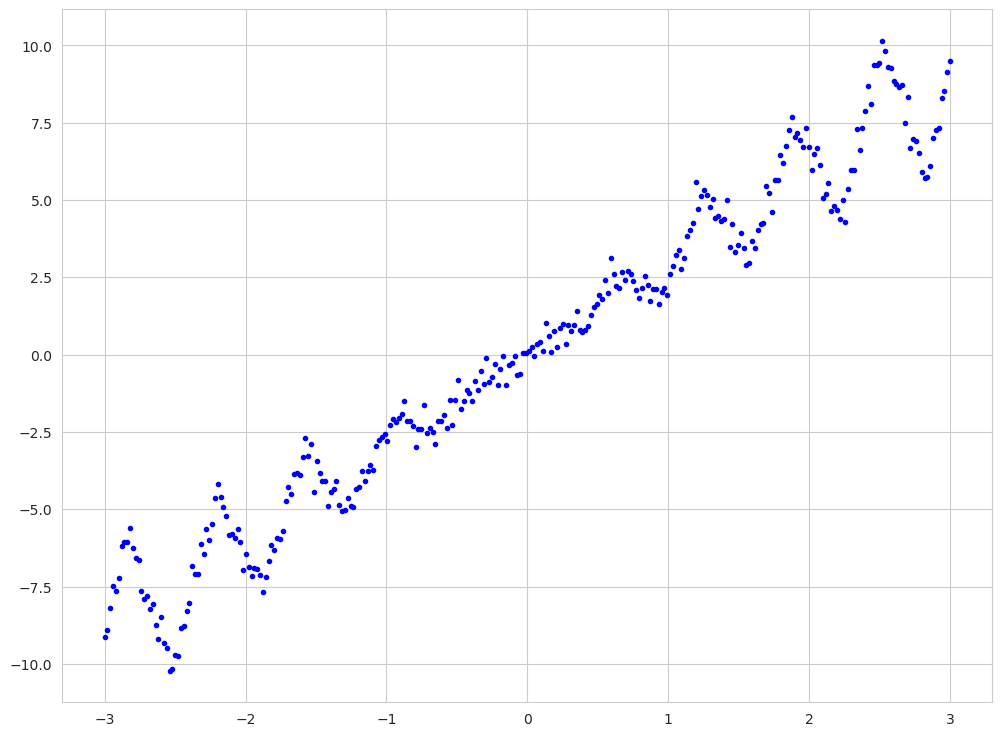

In [3]:
# Сгенерируем какую-нибудь необычную зависимость и научимся ее предсказывать
np.random.seed(42)
m = 300
X = np.linspace(-3, 3, m).reshape(-1, 1)
y = (3 + 2/np.pi * np.arcsin(np.cos(10 * X))) * X
y = y + np.random.randn(m, 1) / 3
plt.plot(X.reshape(-1), y.reshape(-1), "b.");

In [4]:
# Функция для отрисовки предсказаний деревьев решений в случае регрессии
def plot_regression_predictions(tree_reg, X, y, axes=[-3, 3, -10, 10], ylabel="$y$"):
    x1 = np.linspace(axes[0], axes[1], 500).reshape(-1, 1)
    y_pred = tree_reg.predict(x1)
    plt.axis(axes)
    plt.xlabel("$x_1$", fontsize=18)
    if ylabel:
        plt.ylabel(ylabel, fontsize=18, rotation=0)
    plt.scatter(X, y, s=1, color="darkslateblue")
    plt.plot(x1, y_pred, linewidth=2, label=r"$\hat{y}$", color="indianred")

Изобразите, как меняются предсказания дерева при увеличении максимальной глубины (можно взять что-то в диапазоне от 1 до 15):

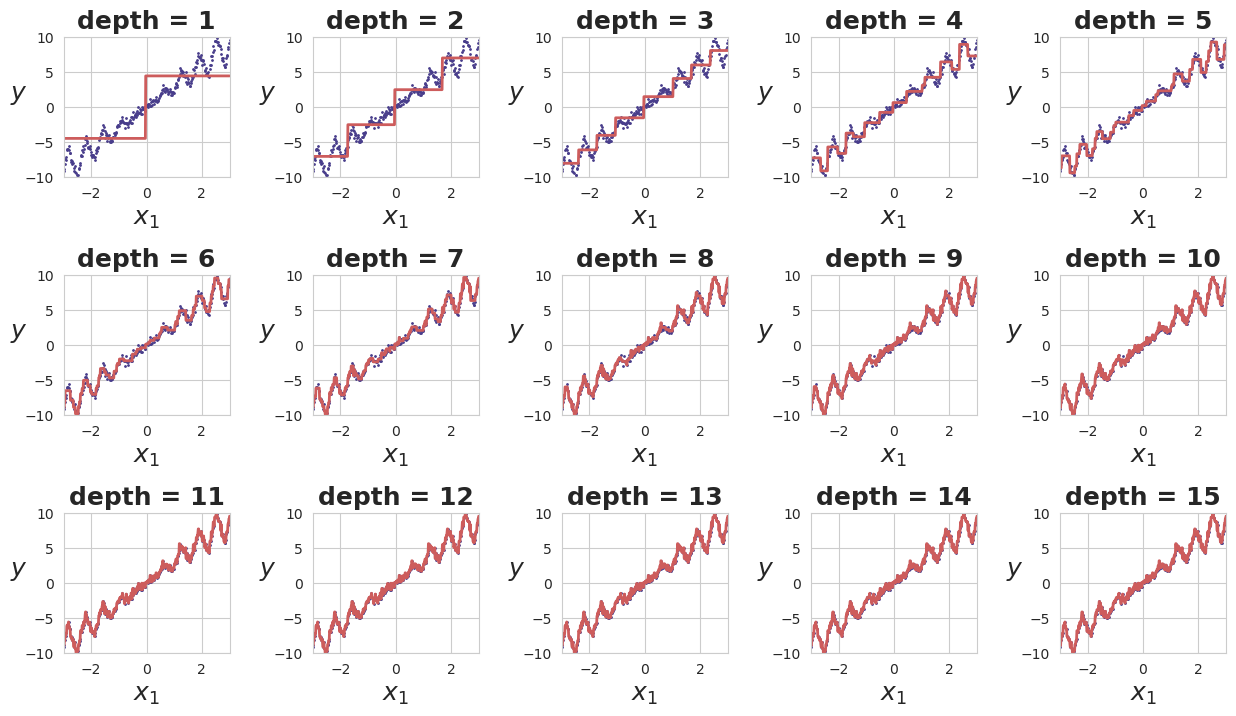

In [5]:
plt.figure(figsize=(15, 8))

for depth in range(1, 16):
    plt.subplot(3, 5, depth)
    plt.title(f'depth = {depth}', weight="bold", fontsize=18)
    tree = DecisionTreeRegressor(max_depth=depth)
    tree.fit(X, y)
    plot_regression_predictions(tree, X, y)
    plt.subplots_adjust(wspace=0.5, hspace=0.7)

Модели с глубиной 6 и выше выглядят переобученными

Попробуем взять несколько случайных наборов точек и оценить bias и variance. Обе этих ошибки должны уменьшаться:
- Оптимальное значение bias — низкое значение, что свидетельствует о низкой ошибке на обучающих данных.
- Оптимальное значение variance — низкое значение, что говорит о стабильности модели относительно изменений в данных. 

Tree depth: 1 Average Expected Loss: 46.5683 Average Bias: 2732.4193 Average Variance: 1.0280
Tree depth: 2 Average Expected Loss: 52.3256 Average Bias: 3061.4146 Average Variance: 1.3020
Tree depth: 3 Average Expected Loss: 54.0521 Average Bias: 3219.2165 Average Variance: 0.3985
Tree depth: 4 Average Expected Loss: 54.2635 Average Bias: 3239.6828 Average Variance: 0.2688
Tree depth: 5 Average Expected Loss: 54.2859 Average Bias: 3244.3044 Average Variance: 0.2142
Tree depth: 6 Average Expected Loss: 54.0320 Average Bias: 3232.1457 Average Variance: 0.1629
Tree depth: 7 Average Expected Loss: 54.1931 Average Bias: 3242.5789 Average Variance: 0.1501
Tree depth: 8 Average Expected Loss: 54.2927 Average Bias: 3248.5904 Average Variance: 0.1495
Tree depth: 9 Average Expected Loss: 54.3631 Average Bias: 3252.7809 Average Variance: 0.1501
Tree depth: 10 Average Expected Loss: 54.3752 Average Bias: 3253.5165 Average Variance: 0.1499
Tree depth: 11 Average Expected Loss: 54.3775 Average Bias:

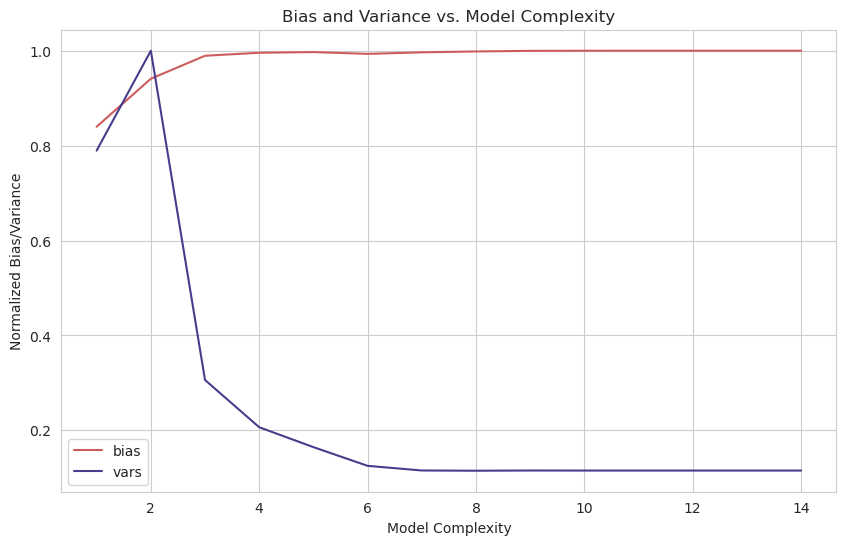

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

biases = []
variances = []

for i in range(1,15):
    regressor = DecisionTreeRegressor(max_depth=i, random_state=42)

    avg_expected_loss, avg_bias, avg_var = bias_variance_decomp(regressor, X_train, y_train, X_test, y_test, 
                                                            loss='mse', num_rounds=200, random_seed=42)
    biases.append(avg_bias)
    variances.append(avg_var)
    print ('Tree depth:', i, end= ' ')
    print('Average Expected Loss: {:.4f}'.format(avg_expected_loss), end= ' ')
    print('Average Bias: {:.4f}'.format(avg_bias), end= ' ')
    print('Average Variance: {:.4f}'.format(avg_var))
    
variances = np.array(variances)
biases = np.array(biases)

plt.figure(figsize=(10, 6))
plt.plot([i for i in range(1,15)],biases/biases.max(),label='bias', color = 'indianred')
plt.plot([i for i in range(1,15)],variances/variances.max(),label='vars', color = 'darkslateblue')
plt.xlabel('Model Complexity')
plt.ylabel('Normalized Bias/Variance')
plt.title('Bias and Variance vs. Model Complexity')
plt.legend()
plt.show();

Получается, по Bias-variance trade-off оптимальными деревьями являются 3 или 4

### Задание 2. Random forest

Теперь давайте немного подготовимся к тому, чтобы реализовать свой собственный случайный лес, а потом реализуем его.

#### Задание 2. 1. Простое ансамблирование

**1 балла**

Представим, что у нас есть 101 классификатор. Каждый может с вероятностью `p` (равной для всех моделей) правильно предсказать класс объекта. Будем делать предсказания по большинству голосов (majority vote). Постройте зависимость вероятности правильно классифицировать объект от значения `p`. Вам может быть полезная следующая формула:

$$ \large \mu = \sum_ {i = 51} ^ {101} C_{101} ^ ip ^ i (1-p) ^ {101-i} $$

Вероятность того, что по крайней мере половина из 101 классификаторах посчитают объект правильно, может быть выражена следующим образом:

[ P(\text{Правильная классификация}) = \sum_{k=51}^{101} \binom{101}{k} p^k (1-p)^{101-k} ]

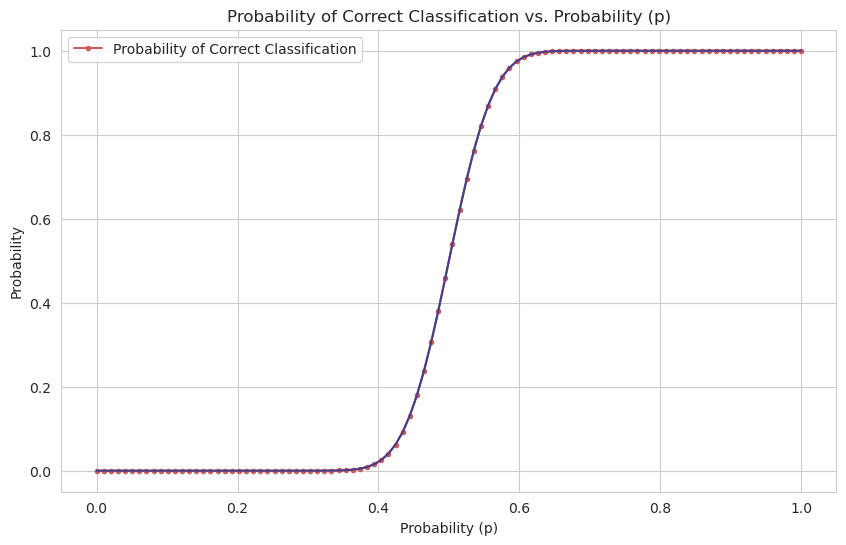

In [7]:
p_values = np.linspace(0, 1, 100)
probabilities = []

for p in p_values:
    prob_correct = sum([np.math.comb(101, k) * p**k * (1-p)**(101-k) for k in range(51, 102)])
    probabilities.append(prob_correct)

plt.figure(figsize=(10, 6))
plt.plot(p_values, probabilities, label='Probability of Correct Classification', marker = '.', color = 'indianred')
plt.plot(p_values, probabilities, color = 'darkslateblue')
plt.xlabel('Probability (p)')
plt.ylabel('Probability')
plt.title('Probability of Correct Classification vs. Probability (p)')
plt.legend()
plt.show();

А теперь давайте посмотрим на другую ситуацию. У нас есть фиксированная вероятность того, что модель правильно классифицирует объект `p = 0.65`. Постройте зависимость вероятности правильно классифицировать объект от числа моделей в ансамбле.

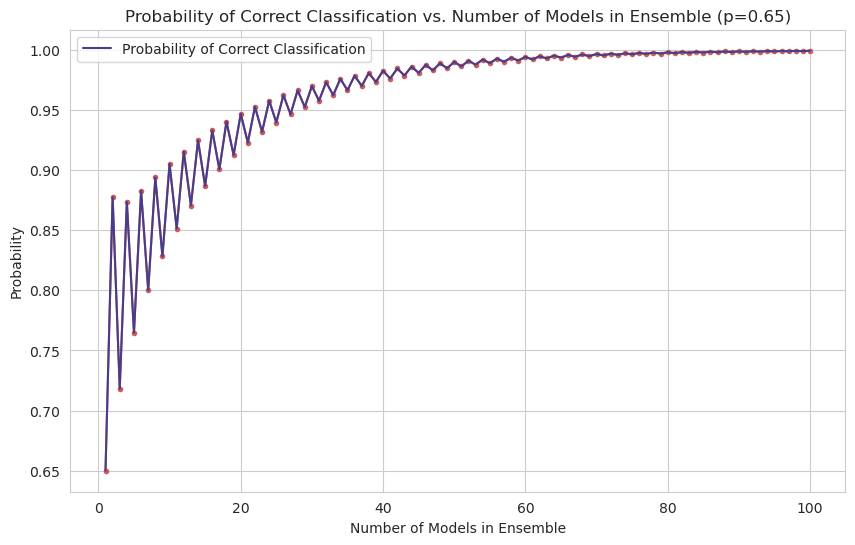

In [8]:
p = 0.65
N_values = np.arange(1, 101)
probabilities = []

for N in N_values:
    prob_correct = sum([np.math.comb(N, k) * p**k * (1-p)**(N-k) for k in range((N+1)//2, N+1)])
    probabilities.append(prob_correct)

plt.figure(figsize=(10, 6))
plt.plot(N_values, probabilities, 
         marker = '.', color = 'indianred')
plt.plot(N_values, probabilities,
         label='Probability of Correct Classification', color = 'darkslateblue')
plt.xlabel('Number of Models in Ensemble')
plt.ylabel('Probability')
plt.title('Probability of Correct Classification vs. Number of Models in Ensemble (p=0.65)')
plt.legend()
plt.show()

Опишите ваши наблюдения:

* Каждый из 101 модели должна иметь вероятность 0.6 и выше для предсказания правильного класса, чтобы при предсказании по большинству голосов вероятность правильного предсказания класса была 0,98 и выше
* Если каждая модель правильно предсказывает класс с вероятностью 0,65, общая вероятность правильной классификации составляет 0,95 и более, если используется 29 и более моделей

> Интересно, что нужно использовать нечетное число моделей в ансамбле при голосовании большинством. При нечетном количестве невозможна "ничья". В такой ситуации имеется четкое большинство, что упрощает принятие окончательного решения.

#### Задание 2. 2. Реализация простого RF

**4 балла**

Реализуйте свой собственный класс `RandomForestClassifierCustom`, используя в качестве базовой модели `DecisionTreeClassifier` из `sklearn`.

Небольшое описание:
- Используйте приведенный ниже код
- В методе `fit` в цикле (`i` от 0 до `n_estimators-1`):
    * Зафиксируйте генератор случайных чисел следующим образом np.random.seed(`random_state + i`). Идея в том, что на каждой итерации у нас будет новое значение для генератора случайных чисел, что добавит побольше "случайности", но в то же время мы сможем иметь воспроизводимые результаты
    * После чего выберите `max_features` признаков **без возвращения/without replacement**, сохраните список выбранных признаков (их индексов) в `self.feat_ids_by_tree`
    * Также создайте псевдовыборку при помощи бутстрэпа (выбор **с возвращением/with replacement**) из тренировочных данных. Может помочь функция `np.random.choice` и ее аргумент `replace`
    * Обучите дерево решений с параметрами, заданными в конструкторе класса `max_depth`, `max_features` и `random_state` на полученной псевдовыборке.
- Метод `fit` должен возвращать текущий экземпляр класса `RandomForestClassifierCustom`, то есть `self` (все по-взрослому, как в `sklearn`)
- В методе `predict_proba` мы должны пройти циклом по всем деревьям. Для каждого предсказания, нам нужно будет брать только те признаки, на которых училось изначальное дерево, поэтому мы и сохраняли эту информацию в артрибуте `self.feat_ids_by_tree`. Этот метод должен возвращать предсказанные вероятности (можно делать двумя способами: для каждого дерева предсказывать значение при помощи метода `predict_proba` и потом усреднять эти вероятности, или к примеру пользоваться методом `predict` и также считать среднее.

In [9]:
class RandomForestClassifierCustom(BaseEstimator):
    def __init__(
        self, n_estimators=10, max_depth=None, max_features=None, random_state=SEED
    ):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.max_features = max_features
        self.random_state = random_state

        self.trees = []
        self.feat_ids_by_tree = []

    def fit(self, X, y):
        self.classes_ = sorted(np.unique(y))
        
        for i in range (self.n_estimators):
            np.random.seed(seed=self.random_state + i)

            # выбераем max_features признаков без возвращения/without replacement
            features_ids = np.random.choice(X.shape[1], size = self.max_features, replace = False)
            self.feat_ids_by_tree.append(features_ids)

            # создаем псевдовыборку бутстрэпом
            sample_ids = np.random.choice(range(X.shape[0]), X.shape[0], replace = True)
            X_sample = X[sample_ids][:, features_ids]
            y_sample = y[sample_ids]
            
            # обучаем дерево
            tree = DecisionTreeClassifier(max_depth=self.max_depth,
                                          max_features=self.max_features,
                                          random_state=self.random_state)
            tree.fit(X_sample, y_sample)
            self.trees.append(tree)
        return self

    def predict_proba(self, X):
        y_proba = []
        tree_num = 0
        for tree in self.trees:
            tree_y_proba = tree.predict_proba(X[:, self.feat_ids_by_tree[tree_num]])
            tree_num += 1
            y_proba.append(tree_y_proba)
        return np.array(y_proba).mean(axis=0)
    
    def predict(self, X):
        probas = self.predict_proba(X)
        predictions = np.argmax(probas, axis=1)
        
        return predictions

Протестируем нашу реализацию на искусственных данных. Визуализируйте разделяющую границу, которую рисует ваша модель при помощи функции `plot_decision_boundary` (см. примеры в лекции).

In [10]:
def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(["#ffdab9","#9898ff", "#4B0082"])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(["#ffdab9", "#4c4c7f", "#4B0082"])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

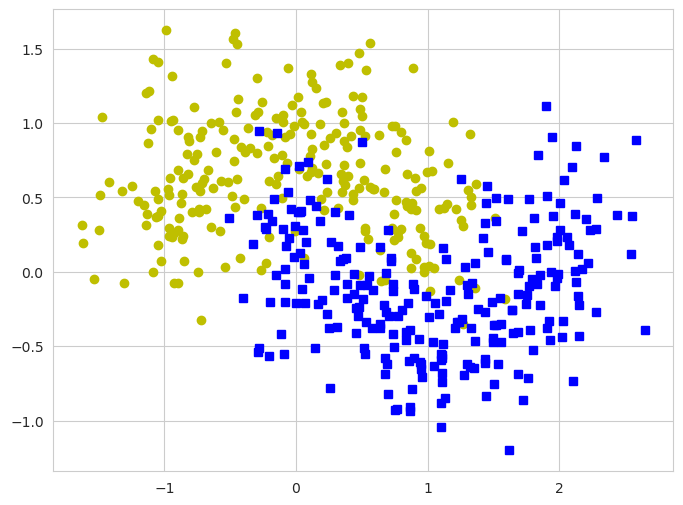

In [11]:
X, y = datasets.make_moons(n_samples=500, noise=0.30, random_state=SEED)

plt.figure(figsize=(8, 6))
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo")
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs")
plt.show()

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2,
                                                    random_state=SEED)

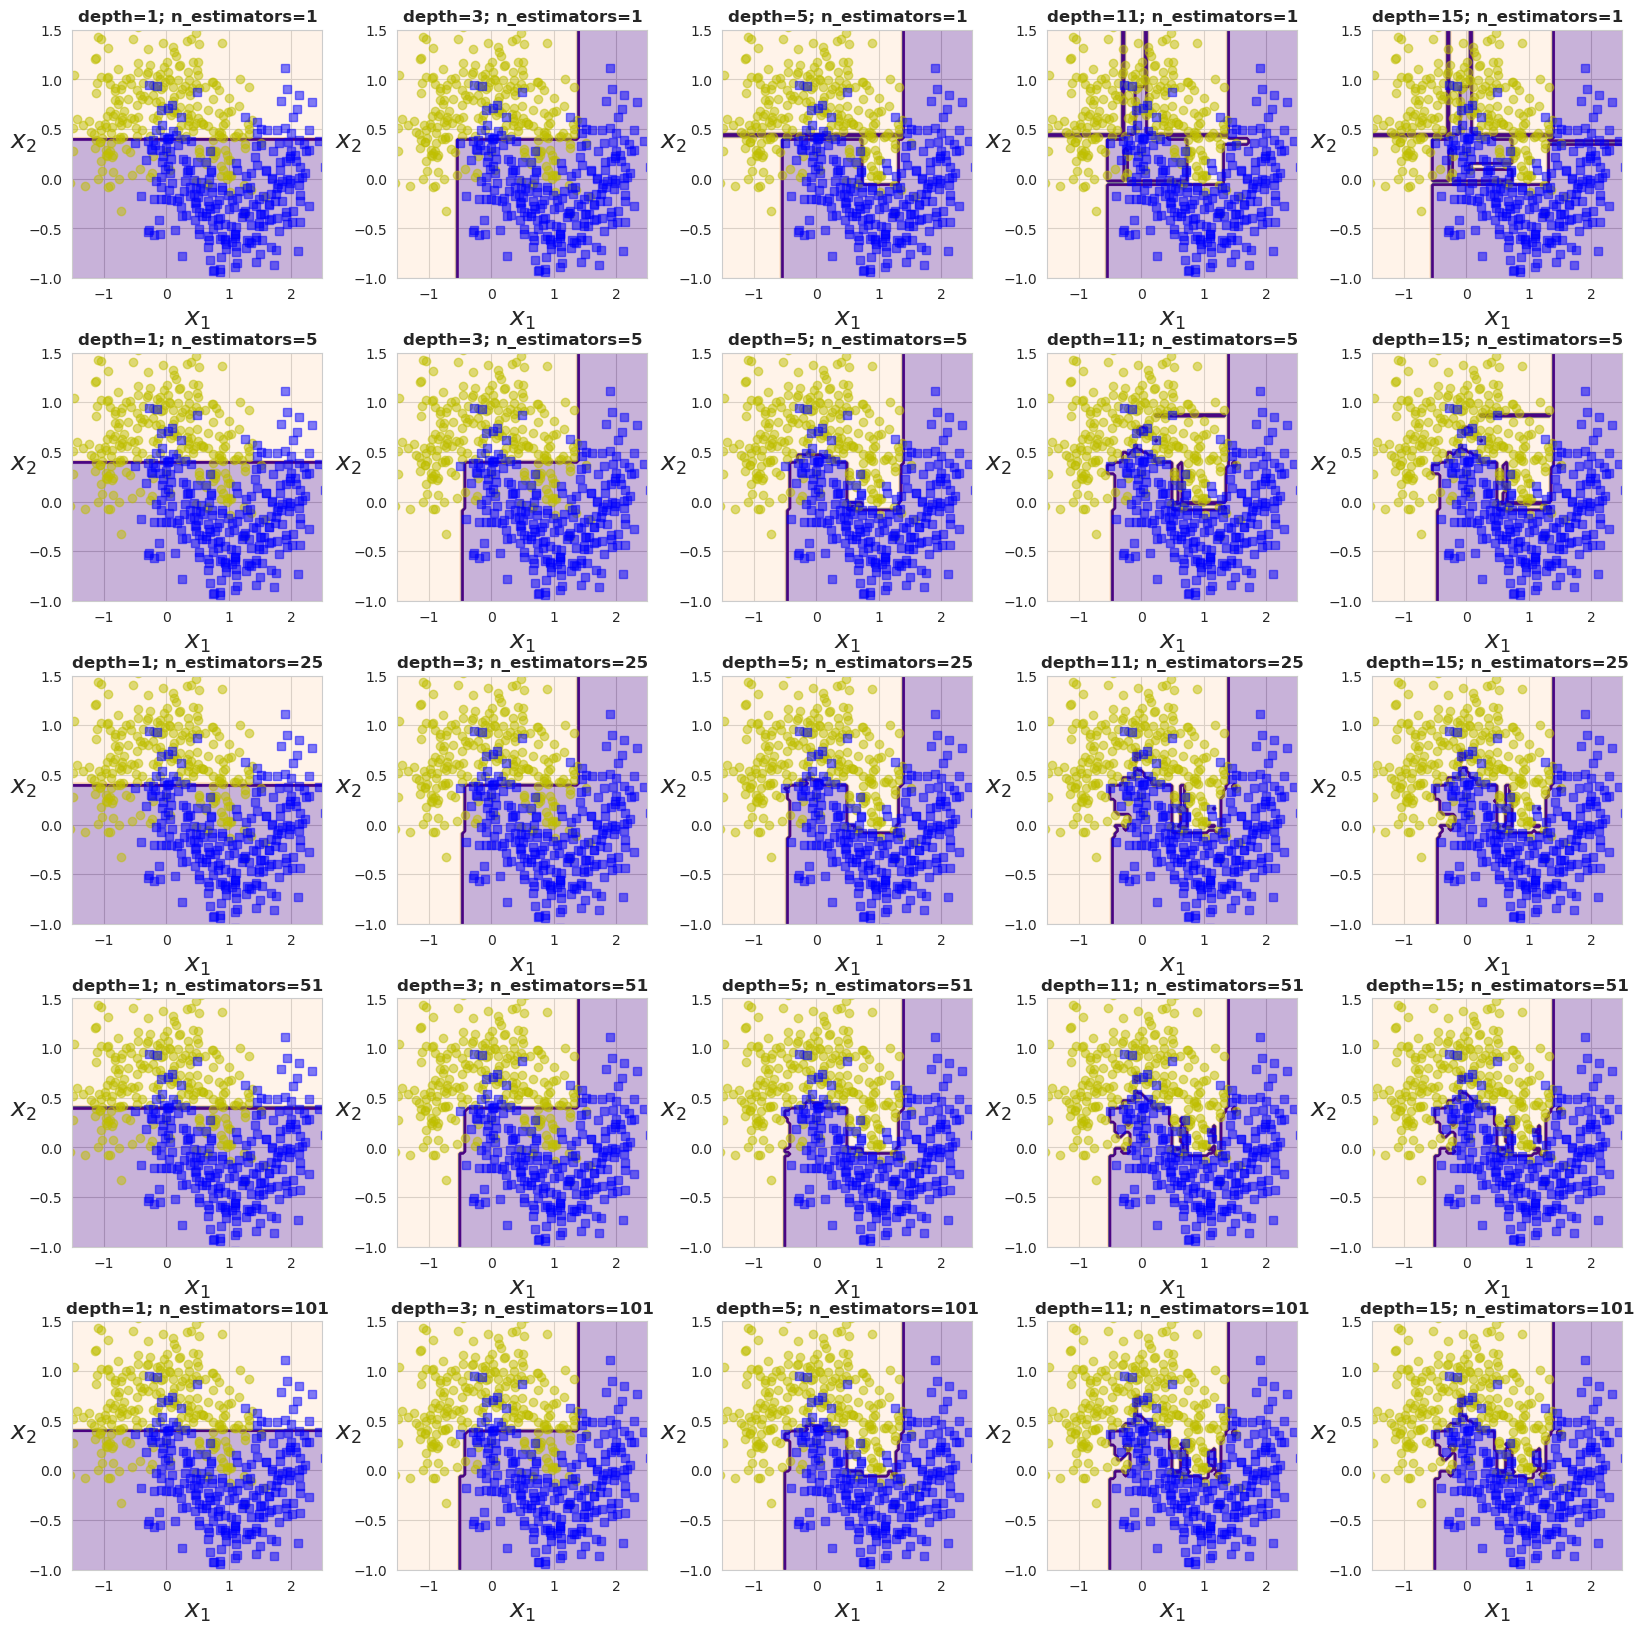

In [13]:
fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(20, 20))
counter_figs = 1
for est in [1, 5, 25, 51, 101]:
    for depth in [1, 3, 5, 11, 15]:
        random_forest = RandomForestClassifierCustom(n_estimators=est,
                                                           max_depth=depth,
                                                           max_features=2,
                                                          )
        random_forest.fit(X_train, y_train)
        ax1 = plt.subplot(5, 5, counter_figs)
        plot_decision_boundary(random_forest, X, y)
        ax1.set_title(f'depth={depth}; n_estimators={est}', weight='bold')
        plt.subplots_adjust(wspace=0.3, hspace=0.3)
        
        counter_figs += 1

Оптимальным кажется лес с `n_estimators > 25` и `depth = 5`

Подберите наилучшие гиперпараметры, при которых разделяющая граница будет, на ваш взгляд, оптимальной с точки зрения bias-variance. Можно также подключить какие-то метрики для выбора лучшей модели.

In [14]:
n_est = range(1, 50)
tree_depth = range(1, 20)
best_bias = float('inf')
best_variance_for_best_bias = 0
best_depth_bias = 0
best_estimators_bias = 0

for depth in tree_depth:
    for n in n_est:
        random_forest = RandomForestClassifierCustom(n_estimators=n,
                                                           max_depth=depth,
                                                           max_features=2,
                                                          )
        avg_expected_loss, avg_bias, avg_var = bias_variance_decomp(
            random_forest, 
            X_train, y_train, X_test, y_test, 
            loss='0-1_loss', 
            num_rounds=5, 
            random_seed=123)
        if avg_bias < best_bias:
            best_bias = avg_bias
            best_depth_bias = depth
            best_estimators_bias = n
            best_variance_for_best_bias = avg_var

print(f'Best bias: {best_bias} for depth={best_depth_bias} and n_estimators={best_estimators_bias}')
print(f'Best variance for the best bias: {best_variance_for_best_bias}')

Best bias: 0.07 for depth=5 and n_estimators=7
Best variance for the best bias: 0.01


Получается, что можно уменьшить `n_estimators` до 7. Глубину определили верно

Посмотрим на точность модели с помощью метрики **accuracy**. Возможно, что 7 деревьев - это мало

In [15]:
best_n_est = None
best_accuracy_score = 0

for n in n_est:
    random_forest = RandomForestClassifierCustom(n_estimators=n, max_depth=5, max_features=2)
        
    random_forest.fit(X_train, y_train)
        
    y_pred = random_forest.predict(X_test)
        
    accuracy = accuracy_score(y_test, y_pred)
    if accuracy > best_accuracy_score:
        best_accuracy_score = accuracy
        best_n_est = n
        
print(f'Best accuracy is {best_accuracy_score} for depth = {5} and n_estimators = {n}')

Best accuracy is 0.93 for depth = 5 and n_estimators = 49


Проверим, что при таких условия bias-varince остается хорошим

In [16]:
random_forest_final = RandomForestClassifierCustom(n_estimators=49,
                                                   max_depth=5,
                                                   max_features=2
                                                   )
avg_expected_loss, avg_bias, avg_var = bias_variance_decomp(
    random_forest_final, 
    X_train, y_train, X_test, y_test, 
    loss='0-1_loss', 
    num_rounds=100, 
    random_seed=123)

print(f'Bias: {avg_bias} for depth = 5 and n_estimators = 49')
print(f'Variance: {avg_var} for depth = 5 and n_estimators = 49')

Bias: 0.07 for depth = 5 and n_estimators = 49
Variance: 0.0005 for depth = 5 and n_estimators = 49


Кажется, все оптимизировали. Выбираем лес с `n_estimators = 49` и `depth = 5`

#### Задание 2. 3. Корреляция базовых моделей

**3 балла**

Как мы выянили на лекции, для того, чтобы bagging работал хорошо, предсказания наших моделей не должны сильно коррелировать. Для этого в случайном лесе применяются различные подходы, в том числе и RSM. Давайте посмотрим, как влияет параметр `max_features` на корреляцию базовых моделей в случайном лесу из `sklearn`. В качестве примера будем использовать датасет `breast_cancer`. Для расчета корреляций используйте приведенную ниже функцию `base_model_pair_correlation`. Для каждой модели у вас будет получаться набор значений (попарные корреляции всех деревьев), дальше можно изобразить их в виде боксплотов, как мы на лекции рисовали распределение метрик.

In [17]:
# Функция для расчета попарных корреляций базовых моделей в случайном лесу
def base_model_pair_correlation(ensemble, X):
    corrs = []
    for (i, est1), (j, est2) in combinations(enumerate(ensemble.estimators_), 2):
        Xi_test = X
        Xj_test = X

        ypred_t1 = est1.predict_proba(Xi_test)[:, 1]
        ypred_t2 = est2.predict_proba(Xj_test)[:, 1]

        corrs.append(pearsonr(ypred_t1, ypred_t2)[0])
    return np.array(corrs)

In [18]:
# Загрузим данные
breast_cancer = datasets.load_breast_cancer()
X = breast_cancer.data
y = breast_cancer.target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

Посмотрим на данные

In [19]:
feature_names = breast_cancer["feature_names"]
X = pd.DataFrame(X, columns=feature_names)
X.head()

mean radius  mean texture  mean perimeter  mean area  mean smoothness  \
0        17.99         10.38          122.80     1001.0          0.11840   
1        20.57         17.77          132.90     1326.0          0.08474   
2        19.69         21.25          130.00     1203.0          0.10960   
3        11.42         20.38           77.58      386.1          0.14250   
4        20.29         14.34          135.10     1297.0          0.10030   

   mean compactness  mean concavity  mean concave points  mean symmetry  \
0           0.27760          0.3001              0.14710         0.2419   
1           0.07864          0.0869              0.07017         0.1812   
2           0.15990          0.1974              0.12790         0.2069   
3           0.28390          0.2414              0.10520         0.2597   
4           0.13280          0.1980              0.10430         0.1809   

   mean fractal dimension  ...  worst radius  worst texture  worst perimeter  \
0                 0.07871  ...         25.38          17.33           184.60   
1                 0.05667  ...         24.99          23.41           158.80   
2                 0.05999  ...         23.57          25.53           152.50   
3                 0.09744  ...         14.91          26.50            98.87   
4                 0.05883  ...         22.54          16.67           152.20   

   worst area  worst smoothness  worst compactness  worst concavity  \
0      2019.0            0.1622             0.6656           0.7119   
1      1956.0            0.1238             0.1866           0.2416   
2      1709.0            0.1444             0.4245           0.4504   
3       567.7            0.2098             0.8663           0.6869   
4      1575.0            0.1374             0.2050           0.4000   

   worst concave points  worst symmetry  worst fractal dimension  
0                0.2654          0.4601                  0.11890  
1                0.1860          0.2750                  0.08902  
2                0.2430          0.3613                  0.08758  
3                0.2575          0.6638                  0.17300  
4                0.1625          0.2364                  0.07678  

[5 rows x 30 columns]

Есть 30 признаков. Посмотрим на корреляцию базовых моделей при глубине дерева 5

In [20]:
res_corr = []
test_features = [1, 2, 3, 4, 5, 10, 15, 20, 30]

for features in test_features:
    model = RandomForestClassifier(max_features=features, max_depth = 5, random_state=SEED)
    fitted_f = model.fit(X_train, y_train)
    corr_by_pairs = base_model_pair_correlation(fitted_f, X_test)
    res_corr.append(corr_by_pairs)

In [21]:
results = pd.DataFrame(np.array(res_corr).T, columns=test_features)
results

1         2         3         4         5         10        15  \
0     0.781311  0.769632  0.803328  0.862875  0.888857  0.782479  0.860661   
1     0.727447  0.759643  0.765188  0.766468  0.871643  0.830240  0.811896   
2     0.829277  0.692008  0.759292  0.822629  0.853045  0.910892  0.876168   
3     0.770156  0.783448  0.728791  0.791314  0.908651  0.852722  0.841063   
4     0.718984  0.708284  0.687222  0.784399  0.929240  0.855018  0.770763   
...        ...       ...       ...       ...       ...       ...       ...   
4945  0.768939  0.837594  0.873223  0.828515  0.822805  0.890077  0.828013   
4946  0.699041  0.751701  0.817313  0.868757  0.788618  0.804965  0.783546   
4947  0.799385  0.780455  0.892618  0.935202  0.862851  0.973390  0.853884   
4948  0.777036  0.729241  0.749813  0.785503  0.826234  0.834443  0.780013   
4949  0.725237  0.767015  0.757789  0.835286  0.759131  0.821935  0.746246   

            20        30  
0     0.838887  0.894865  
1     0.869431  0.869905  
2     0.857553  0.954322  
3     0.851359  0.906790  
4     0.866710  0.882657  
...        ...       ...  
4945  0.780013  0.817982  
4946  0.729178  0.737927  
4947  0.807386  0.920777  
4948  0.756860  0.750140  
4949  0.711725  0.729744  

[4950 rows x 9 columns]

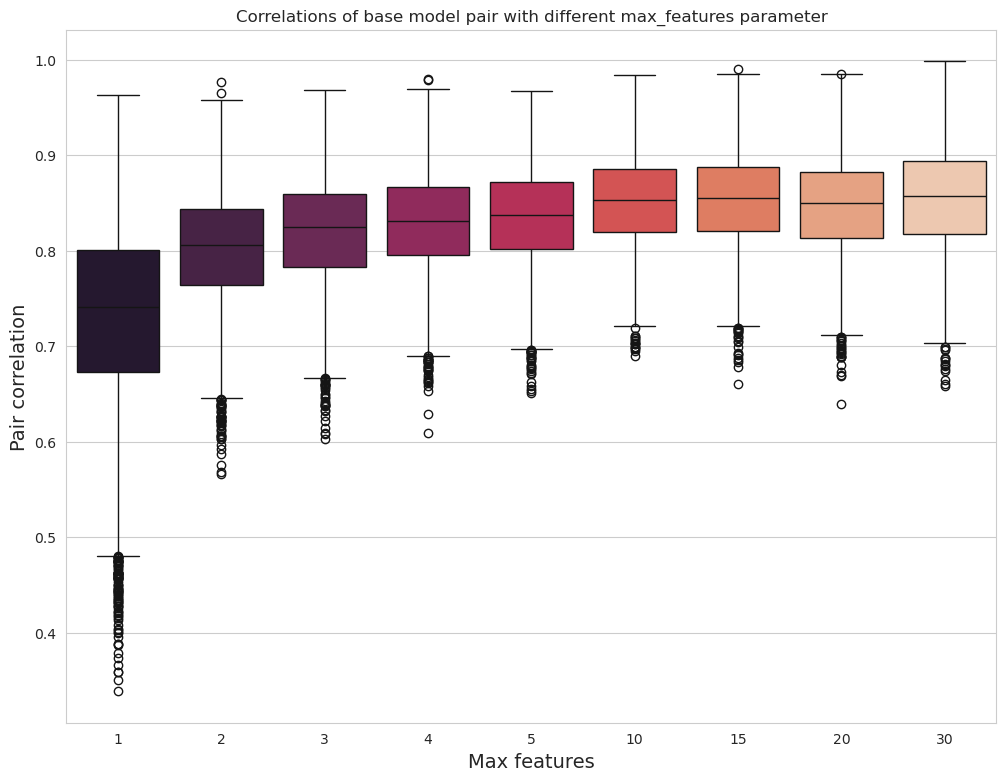

In [22]:
sns.boxplot(data=results, palette = 'rocket')
plt.title("Correlations of base model pair with different max_features parameter")
plt.xlabel("Max features", size=14)
plt.ylabel("Pair correlation", size=14);

Теперь давайте посмотрим, как на это влияет параметр `max_depth`:

In [23]:
res_corr = []
test_depth = [1, 2, 3, 4, 5, 10, 15, 20, 30]

for depth in test_depth:
    model = RandomForestClassifier(max_depth = depth, random_state=SEED) # max_features=sqrt(n_features) 
    fitted_f = model.fit(X_train, y_train)
    corr_by_pairs = base_model_pair_correlation(fitted_f, X_test)
    res_corr.append(corr_by_pairs)

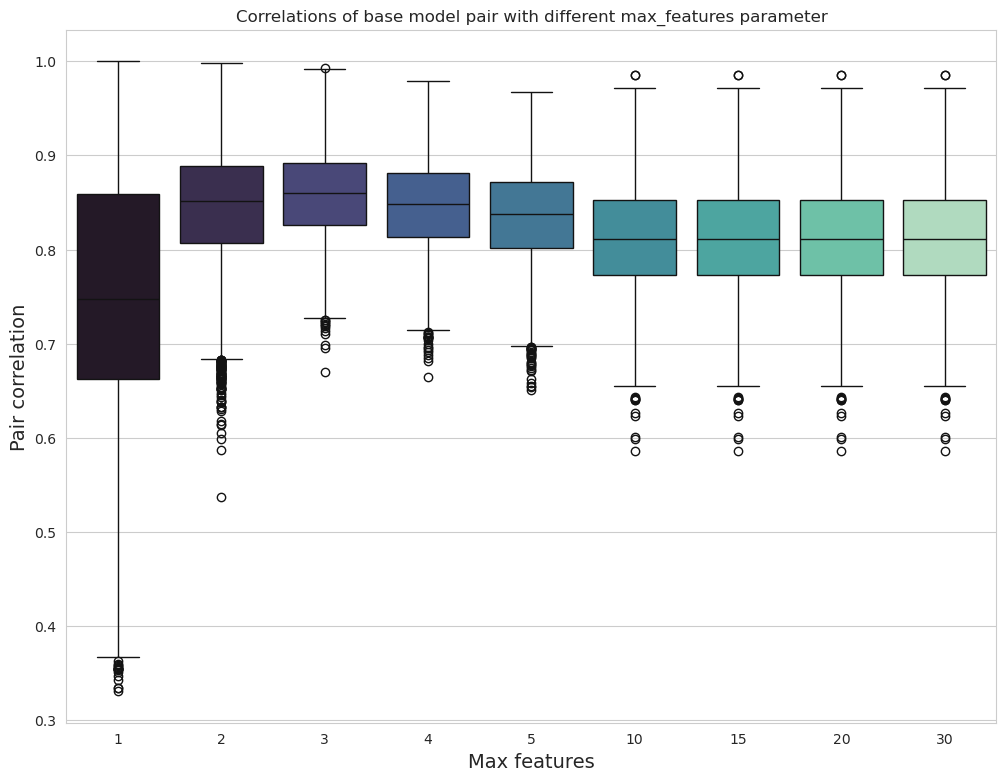

In [24]:
results = pd.DataFrame(np.array(res_corr).T, columns=test_features)
sns.boxplot(data=results, palette = 'mako')
plt.title("Correlations of base model pair with different max_features parameter")
plt.xlabel("Max features", size=14)
plt.ylabel("Pair correlation", size=14);

Опишите ваши наблюдения:

* При увеличении количества признаков видим увеличение корреляции базовых моделей
* При увеличении глубины дерева при построении базовой модели видим снижение корреляции между базовыми моделями. Еще здесь аблюдается выход на плато при значения  `max_depth` больше 10. 

> Интересно, что при `max_features = 1` или `max_depth = 1` боксплот растянутый, что говорит о сложной предсказуемости корреляции.

### Задание 3. Строим большой ансамбль

**4 балла + 3 дополнительных за скор выше 0.87**

В данной задаче вам нужно диагностировать сердечное заболевание у людей по медицинским показателям.

In [25]:
#!gdown  --id 1VFbDK-Ad-hpf0_GGCBzn4thdn9mkQ-Y- -O heart.csv -q
heart_dataset = pd.read_csv("../data/heart.csv")
heart_dataset.head()

age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   63    1   3       145   233    1        0      150      0      2.3      0   
1   37    1   2       130   250    0        1      187      0      3.5      0   
2   41    0   1       130   204    0        0      172      0      1.4      2   
3   56    1   1       120   236    0        1      178      0      0.8      2   
4   57    0   0       120   354    0        1      163      1      0.6      2   

   ca  thal  target  
0   0     1       1  
1   0     2       1  
2   0     2       1  
3   0     2       1  
4   0     2       1

Колонки такие:

- age - числовая колонка
- sex - категориальная колонка
- chest pain type (4 values) - категориальная колонка
- resting blood pressure - числовая колонка
- serum cholestoral in mg/dl - числовая колонка
- fasting blood sugar > 120 mg/dl - числовая колонка
- resting electrocardiographic results (values 0,1,2) - категориальная колонка
- maximum heart rate achieved - числовая колонка
- exercise induced angina - категориальная колонка
- oldpeak = ST depression induced by exercise relative to rest - числовая колонка
- the slope of the peak exercise ST segment - категориальная колонка
- number of major vessels (0-3) colored by flourosopy - категориальная колонка
- thal: 0 = normal; 1 = fixed defect; 2 = reversable defect - категориальная колонка

In [26]:
X = heart_dataset.drop('target', axis=1)
y = heart_dataset['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)
X_train.head()

age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  \
178   43    1   0       120   177    0        0      120      1      2.5   
298   57    0   0       140   241    0        1      123      1      0.2   
201   60    1   0       125   258    0        0      141      1      2.8   
246   56    0   0       134   409    0        0      150      1      1.9   
153   66    0   2       146   278    0        0      152      0      0.0   

     slope  ca  thal  
178      1   0     3  
298      1   0     3  
201      1   1     3  
246      1   2     3  
153      1   1     2

Обучите разнообразные классификаторы, приведенные ниже, а также ансамбль `VotingClassifier` из `sklearn.ensemble`, объединяющий эти классификаторы с помощью жесткого или мякого голосования (параметр `voting =` `'hard'` или `'soft'` соответственно). Оцените качество моделей с помощью кросс-валидации на тренировочном наборе, используя функцию `cross_val_score` и метрику `f1`. Часть моделей отсюда мы не проходили, о них можно почитать дополнительно, но в принципе для задания не очень важно знать принципы их работы (но, если есть время, то почитайте, там интересно).

In [27]:
dt = DecisionTreeClassifier(random_state=SEED, max_depth=10, min_samples_leaf=10)
rf = RandomForestClassifier(n_estimators=50, random_state=SEED)
etc = ExtraTreesClassifier(random_state=SEED)
knn = KNeighborsClassifier(n_neighbors=5, weights="distance")
svc_lin = SVC(kernel='linear', probability=True, random_state=SEED)
svc_rbf = SVC(kernel='rbf', probability=True, random_state=SEED)
cat = catboost.CatBoostClassifier(verbose=0, random_seed=SEED)
lgbm = lightgbm.LGBMClassifier(random_state=SEED)
lgbm_rf = lightgbm.LGBMClassifier(boosting_type="rf", bagging_freq=1, bagging_fraction=0.7, random_state=SEED)
xgb = xgboost.XGBClassifier(random_state=SEED)
xgb_rf = xgboost.XGBRFClassifier(random_state=SEED)
lr = LogisticRegression(solver='liblinear', max_iter=10000)
nb = GaussianNB()

base_models = [("DT", dt), ("RF", rf), 
               ("ETC", etc), ("KNN", knn), 
               ("SVC_LIN", svc_lin), ("SVC_RBF", svc_rbf), 
               ("CAT", cat), ("LGBM", lgbm), 
               ("LGBM_RF", lgbm_rf), ("XGB", xgb), 
               ("XGB_RF", xgb_rf), ("LR", lr), ("NB", nb)]

Здесь могут возникать различные предупреждения при обучении бустингов, не волнуйтесь, все нормально, просто они обычно очень разговорчивые)

In [28]:
voting_hard = VotingClassifier(estimators=base_models, voting='hard')
voting_soft = VotingClassifier(estimators=base_models, voting='soft')

final_score = []
for model in [dt, rf, cat, 
              etc, knn, svc_lin, 
              svc_rbf, xgb, lgbm, xgb_rf, 
              lgbm_rf, lr, nb, voting_hard, voting_soft]: 
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring="f1")
    final_score.append((model.__class__.__name__, scores.mean()))

[LightGBM] [Info] Number of positive: 94, number of negative: 87
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000271 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 181, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.519337 -> initscore=0.077387
[LightGBM] [Info] Start training from score 0.077387
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Li

In [29]:
for model in final_score:
    print(model)

('DecisionTreeClassifier', 0.7943995582729215)
('RandomForestClassifier', 0.8299934376177165)
('CatBoostClassifier', 0.8366672840836973)
('ExtraTreesClassifier', 0.8173182316404823)
('KNeighborsClassifier', 0.6988235294117647)
('SVC', 0.8570816918930125)
('SVC', 0.6933287946919908)
('XGBClassifier', 0.8086934327921604)
('LGBMClassifier', 0.809669484198243)
('XGBRFClassifier', 0.8047314777643964)
('LGBMClassifier', 0.8035644440267067)
('LogisticRegression', 0.8582343104465867)
('GaussianNB', 0.8126302743749552)
('VotingClassifier', 0.8415296665155163)
('VotingClassifier', 0.8466548144749669)


Вы можете заметить, что ансамбль показывает хорошее, но не лучшее качество предсказания, попробуем его улучшить. Как вы знаете, ансамбли работают лучше, когда модели, входящие в них не скоррелированы друг с другом. Определите корреляцию предсказаний базовых моделей в ансамбле на тестовом наборе данных, и удалите из ансамбля те модели, чьи предсказания будут сильнее коррелировать с остальными. Воспользуйтесь функцией `base_model_pair_correlation_for_voting_clf`. **Спойлер**: далеко не факт, что если вы удалите две модели с корреляцией 0.95, то все станет сильно лучше, здесь все будет немного сложнее. Чтобы добиться максимального качества может понадобиться долгий перебор различных комбинаций моделей. Наилучший скор, который мне удалось достичь, это 0.915, но он получен весьма странной комбинацией алгоритмов, а еще и простым перебором всех вариантов)

In [30]:
def base_model_pair_correlation_for_voting_clf(ensemble, X):
    corrs = {}
    base_model_names = [f"{est.__class__.__name__}" for est in ensemble.estimators_]
    for (i, est1), (j, est2) in combinations(enumerate(ensemble.estimators_), 2):
        Xi_test = X
        Xj_test = X

        if not isinstance(est1, SVC):
            ypred_t1 = est1.predict_proba(Xi_test)[:, 1]
        else:
            ypred_t1 = est1.decision_function(Xi_test)


        if not isinstance(est2, SVC):
            ypred_t2 = est2.predict_proba(Xi_test)[:, 1]
        else:
            ypred_t2 = est2.decision_function(Xi_test)
        cor = pearsonr(ypred_t1, ypred_t2)[0]
        corrs[(est1.__class__.__name__, est2.__class__.__name__)] = cor

    return corrs

In [31]:
voting_hard.fit(X_train, y_train)
voting_soft.fit(X_train, y_train)

corr_hard = base_model_pair_correlation_for_voting_clf(voting_hard, X_test)
corr_soft = base_model_pair_correlation_for_voting_clf(voting_hard, X_test)

[LightGBM] [Info] Number of positive: 118, number of negative: 109
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000047 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 236
[LightGBM] [Info] Number of data points in the train set: 227, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.519824 -> initscore=0.079337
[LightGBM] [Info] Start training from score 0.079337
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

In [32]:
sorted_corr_hard = {k: v for k, v in sorted(corr_hard.items(), key=lambda item: item[1])}
sorted_corr_hard

{('SVC', 'XGBClassifier'): 0.2263393781495638,
 ('KNeighborsClassifier', 'GaussianNB'): 0.23137181767934303,
 ('KNeighborsClassifier', 'LogisticRegression'): 0.2697340600205871,
 ('DecisionTreeClassifier', 'SVC'): 0.2820135356695378,
 ('KNeighborsClassifier', 'XGBClassifier'): 0.3033677431501891,
 ('SVC', 'CatBoostClassifier'): 0.31065818680334994,
 ('DecisionTreeClassifier', 'KNeighborsClassifier'): 0.31332949662835446,
 ('KNeighborsClassifier', 'CatBoostClassifier'): 0.31720692942108,
 ('ExtraTreesClassifier', 'KNeighborsClassifier'): 0.322398286410264,
 ('SVC', 'XGBRFClassifier'): 0.3226675632203515,
 ('SVC', 'SVC'): 0.33397170567092727,
 ('ExtraTreesClassifier', 'SVC'): 0.35885458306081897,
 ('KNeighborsClassifier', 'XGBRFClassifier'): 0.3885382656793352,
 ('SVC', 'LGBMClassifier'): 0.38927521996206604,
 ('RandomForestClassifier', 'KNeighborsClassifier'): 0.3924167426564557,
 ('KNeighborsClassifier', 'LGBMClassifier'): 0.4015025760940782,
 ('SVC', 'LogisticRegression'): 0.401674983

[LightGBM] [Info] Number of positive: 118, number of negative: 109
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000050 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 236
[LightGBM] [Info] Number of data points in the train set: 227, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.519824 -> initscore=0.079337
[LightGBM] [Info] Start training from score 0.079337
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

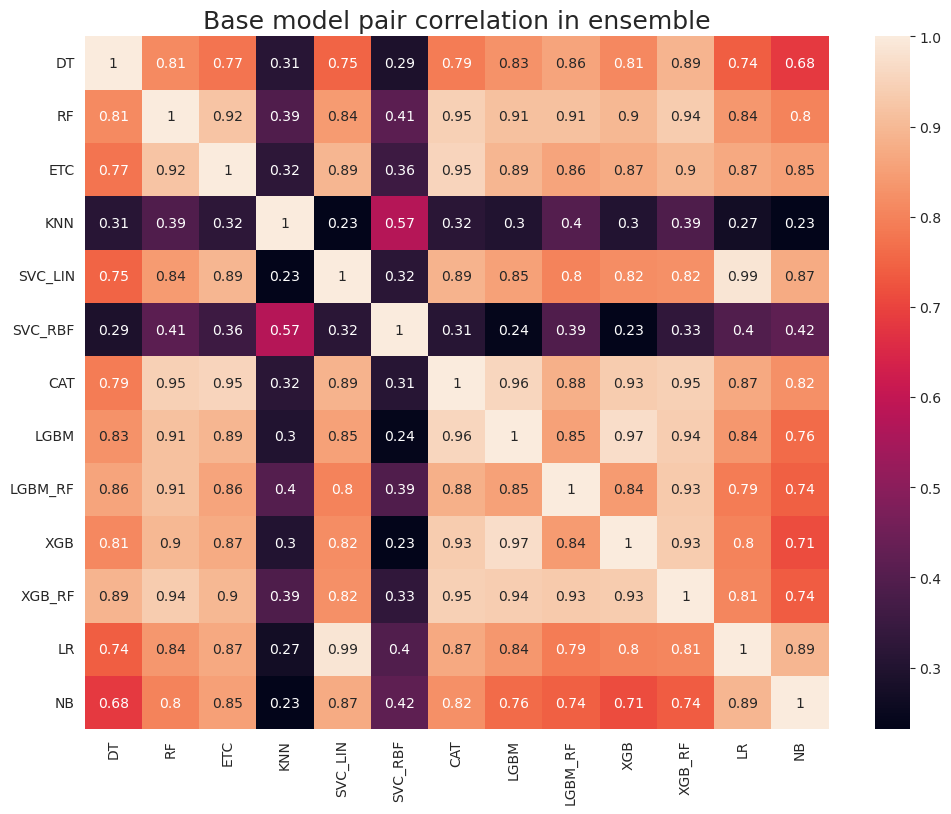

In [33]:
corr_df = {}
for name, model in base_models:
    model.fit(X_train, y_train)
    corr_df[name] = model.predict_proba(X_test)[:, 1]
corr_df = pd.DataFrame(corr_df)
sns.heatmap(corr_df.corr(), annot=True)
plt.title('Base model pair correlation in ensemble', size=18);

In [34]:
final_score

[('DecisionTreeClassifier', 0.7943995582729215),
 ('RandomForestClassifier', 0.8299934376177165),
 ('CatBoostClassifier', 0.8366672840836973),
 ('ExtraTreesClassifier', 0.8173182316404823),
 ('KNeighborsClassifier', 0.6988235294117647),
 ('SVC', 0.8570816918930125),
 ('SVC', 0.6933287946919908),
 ('XGBClassifier', 0.8086934327921604),
 ('LGBMClassifier', 0.809669484198243),
 ('XGBRFClassifier', 0.8047314777643964),
 ('LGBMClassifier', 0.8035644440267067),
 ('LogisticRegression', 0.8582343104465867),
 ('GaussianNB', 0.8126302743749552),
 ('VotingClassifier', 0.8415296665155163),
 ('VotingClassifier', 0.8466548144749669)]

In [35]:
base_models = [("DT", dt), ("RF", rf), 
               ("ETC", etc), ("KNN", knn), 
               ("SVC_LIN", svc_lin), ("SVC_RBF", svc_rbf), 
               ("CAT", cat), ("LGBM", lgbm), 
               ("LGBM_RF", lgbm_rf), ("XGB", xgb), 
               ("XGB_RF", xgb_rf), ("LR", lr), ("NB", nb)]

In [36]:
models =  [('RF', rf), ('KNN', knn), ('LGBM', lgbm), ('SVC_LIN', svc_lin), ('LR', lr)]

best_score = {}
for voting in ['soft', 'hard']:
    clf = VotingClassifier(estimators=models, voting = voting)
    clf.fit(X_train, y_train) 
    scores = cross_val_score(clf, X_train, y_train, cv=5, scoring="f1")
    best_score[voting] = scores.mean()

[LightGBM] [Info] Number of positive: 118, number of negative: 109
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003700 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 236
[LightGBM] [Info] Number of data points in the train set: 227, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.519824 -> initscore=0.079337
[LightGBM] [Info] Start training from score 0.079337
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

In [37]:
print(best_score)

{'soft': 0.8431796769022075, 'hard': 0.8710990447461036}


Получилось подобрать оптимальный ансамбль с учетом взаимной корреляции моделей и их эффективности предсказания.

> Интересно, что в итоговом наборе есть модели, которые сильно коррелируют друг с другом: SVC_LIN и LR. Но если одну из них убрать, то f1 очень падает.

### Задание 4. Определение оттока клиентов из телекома

**6 баллов + 7 дополнительных за высокое качество модели и различные эксперименты**

Будем предсказывать, уйдет ли от нас клиент (переменная `Churn?`). Данные можно скачать [здесь](https://www.kaggle.com/venky12347/churn-telecom). Это будет уже совсем взрослое задание, так как правильного ответа на него нет. Вам нужно будет разобраться с данными, правильно подготовить их для моделей, а также выбрать лучшую модель. 

Задача минимум:

Выберите 2 модели &mdash; один случайный лес и один бустинг из приведенных ниже:

1. `xgboost.XGBClassifier`
2. `xgboost.XGBRFClassifier` &mdash; случайный лес от xgboost
3. `lightgbm.LGBMClassifier`
4. `lightgbm.LGBMClassifier(boosting_type="rf")` &mdash; случайный лес от lightgbm
5. `catboost.CatBoostClassifier`

И попробуйте разобраться с тем, как для этих моделей правильно настраивать гиперпараметры. Советую гуглить примерно следующее `how to choose best hyperparameters for lightgbm`. Там вы найдете кучу сложного и непонятного кода, но если с ним разобраться и научиться обучать нестандартные бустинги, то в плане табличных данных равных вам не будет)

In [38]:
data = pd.read_csv('../data/churn.csv')
data.head()

State  Account Length  Area Code     Phone Int'l Plan VMail Plan  \
0    KS             128        415  382-4657         no        yes   
1    OH             107        415  371-7191         no        yes   
2    NJ             137        415  358-1921         no         no   
3    OH              84        408  375-9999        yes         no   
4    OK              75        415  330-6626        yes         no   

   VMail Message  Day Mins  Day Calls  Day Charge  ...  Eve Calls  Eve Charge  \
0             25     265.1        110       45.07  ...         99       16.78   
1             26     161.6        123       27.47  ...        103       16.62   
2              0     243.4        114       41.38  ...        110       10.30   
3              0     299.4         71       50.90  ...         88        5.26   
4              0     166.7        113       28.34  ...        122       12.61   

   Night Mins  Night Calls  Night Charge  Intl Mins  Intl Calls  Intl Charge  \
0       244.7           91         11.01       10.0           3         2.70   
1       254.4          103         11.45       13.7           3         3.70   
2       162.6          104          7.32       12.2           5         3.29   
3       196.9           89          8.86        6.6           7         1.78   
4       186.9          121          8.41       10.1           3         2.73   

   CustServ Calls  Churn?  
0               1  False.  
1               1  False.  
2               0  False.  
3               2  False.  
4               3  False.  

[5 rows x 21 columns]

**EDA**

In [39]:
data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   State           3333 non-null   object 
 1   Account Length  3333 non-null   int64  
 2   Area Code       3333 non-null   int64  
 3   Phone           3333 non-null   object 
 4   Int'l Plan      3333 non-null   object 
 5   VMail Plan      3333 non-null   object 
 6   VMail Message   3333 non-null   int64  
 7   Day Mins        3333 non-null   float64
 8   Day Calls       3333 non-null   int64  
 9   Day Charge      3333 non-null   float64
 10  Eve Mins        3333 non-null   float64
 11  Eve Calls       3333 non-null   int64  
 12  Eve Charge      3333 non-null   float64
 13  Night Mins      3333 non-null   float64
 14  Night Calls     3333 non-null   int64  
 15  Night Charge    3333 non-null   float64
 16  Intl Mins       3333 non-null   float64
 17  Intl Calls      3333 non-null   i

In [40]:
data.isnull().sum()

State             0
Account Length    0
Area Code         0
Phone             0
Int'l Plan        0
VMail Plan        0
VMail Message     0
Day Mins          0
Day Calls         0
Day Charge        0
Eve Mins          0
Eve Calls         0
Eve Charge        0
Night Mins        0
Night Calls       0
Night Charge      0
Intl Mins         0
Intl Calls        0
Intl Charge       0
CustServ Calls    0
Churn?            0
dtype: int64

In [41]:
data.isna().sum()

State             0
Account Length    0
Area Code         0
Phone             0
Int'l Plan        0
VMail Plan        0
VMail Message     0
Day Mins          0
Day Calls         0
Day Charge        0
Eve Mins          0
Eve Calls         0
Eve Charge        0
Night Mins        0
Night Calls       0
Night Charge      0
Intl Mins         0
Intl Calls        0
Intl Charge       0
CustServ Calls    0
Churn?            0
dtype: int64

Нет пропущенных значений и нулевых. Но нужно еще перекодировать колонку таргета и убрать лишние (считаю, что 'State', 'Area Code', 'Phone' не влияют)

In [42]:
data = data.rename(columns={'Churn?':'Churn'})

bin_feature = ['VMail Plan', "Int'l Plan", 'Churn']
for col in bin_feature:
    data[col].replace({'yes':1,'no':0},inplace=True)
    data[col].replace({'False.':0,'True.':1},inplace=True)

data = data.drop(['State', 'Area Code', 'Phone'], axis=1)

In [43]:
data['Churn'].value_counts()

Churn
0    2850
1     483
Name: count, dtype: int64

О, нашли дисбаланс классов:(

Нужно будет сбалансировать

In [44]:
X = data.drop(['Churn'], axis = 1)
y = data['Churn']

In [45]:
data

Account Length  Int'l Plan  VMail Plan  VMail Message  Day Mins  \
0                128           0           1             25     265.1   
1                107           0           1             26     161.6   
2                137           0           0              0     243.4   
3                 84           1           0              0     299.4   
4                 75           1           0              0     166.7   
...              ...         ...         ...            ...       ...   
3328             192           0           1             36     156.2   
3329              68           0           0              0     231.1   
3330              28           0           0              0     180.8   
3331             184           1           0              0     213.8   
3332              74           0           1             25     234.4   

      Day Calls  Day Charge  Eve Mins  Eve Calls  Eve Charge  Night Mins  \
0           110       45.07     197.4         99       16.78       244.7   
1           123       27.47     195.5        103       16.62       254.4   
2           114       41.38     121.2        110       10.30       162.6   
3            71       50.90      61.9         88        5.26       196.9   
4           113       28.34     148.3        122       12.61       186.9   
...         ...         ...       ...        ...         ...         ...   
3328         77       26.55     215.5        126       18.32       279.1   
3329         57       39.29     153.4         55       13.04       191.3   
3330        109       30.74     288.8         58       24.55       191.9   
3331        105       36.35     159.6         84       13.57       139.2   
3332        113       39.85     265.9         82       22.60       241.4   

      Night Calls  Night Charge  Intl Mins  Intl Calls  Intl Charge  \
0              91         11.01       10.0           3         2.70   
1             103         11.45       13.7           3         3.70   
2             104          7.32       12.2           5         3.29   
3              89          8.86        6.6           7         1.78   
4             121          8.41       10.1           3         2.73   
...           ...           ...        ...         ...          ...   
3328           83         12.56        9.9           6         2.67   
3329          123          8.61        9.6           4         2.59   
3330           91          8.64       14.1           6         3.81   
3331          137          6.26        5.0          10         1.35   
3332           77         10.86       13.7           4         3.70   

      CustServ Calls  Churn  
0                  1      0  
1                  1      0  
2                  0      0  
3                  2      0  
4                  3      0  
...              ...    ...  
3328               2      0  
3329               3      0  
3330               2      0  
3331               2      0  
3332               0      0  

[3333 rows x 18 columns]

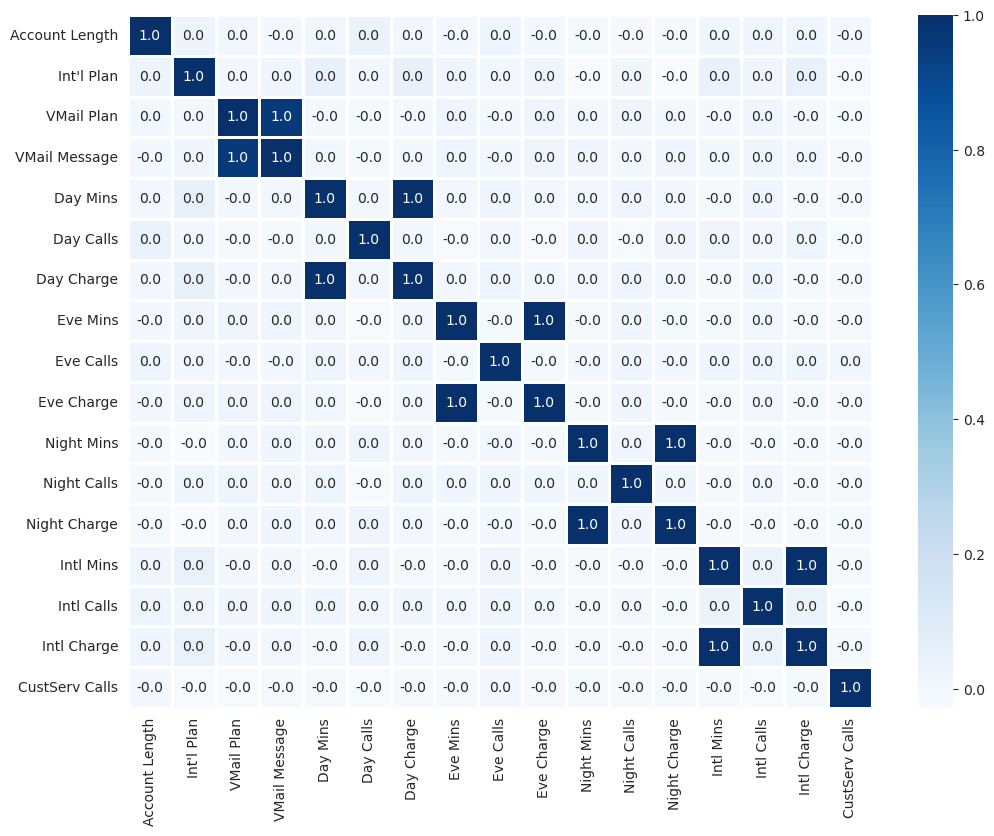

In [46]:
sns.heatmap(X.corr(), 
            linewidths=1, annot=True, 
            fmt=".1f", cmap=sns.color_palette('Blues', as_cmap=True));

Видна идентичность между признаками 'Charge' и 'Mins'. Удалим 'Mins'. Также идентичны 'Vmail Plan' и 'Vmail Message'. Удалим последнее

In [47]:
X = X.drop(["VMail Message", "Day Mins", "Eve Mins", "Night Mins", "Intl Mins"], axis=1)

Начинаем строить модели

In [48]:
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.2, random_state=SEED)

Из предложенных моделей, выберем Random Forest из `lightgbm.LGBMClassifier` в качестве случайного леса и Gradient Boosting из `xgboost.XGBClassifier` в качестве бустинга.

Для настройки гиперпараметров этих моделей можно воспользоваться методами оптимизации, такими как `GridSearchCV`

In [54]:
gb_model = xgboost.XGBClassifier(random_state=42)

# Определяем сетку параметров для Grid Search
param_grid_gb = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [3, 5, 7]
}

# Инициализируем Grid Search с кросс-валидацией
gb_grid = GridSearchCV(gb_model, param_grid_gb, cv=3)

# Обучаем модель с Grid Search
gb_grid.fit(X_train, y_train)

# Выводим лучшие параметры модели
print("Best params XGBoost Gradient Boosting:", gb_grid.best_params_)

Лучшие параметры для XGBoost Gradient Boosting: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100}


In [62]:
gb_model_best = xgboost.XGBClassifier(random_state=42,
                                      learning_rate = 0.1,
                                      max_depth =7,
                                      n_estimators = 100)
gb_model_best.fit(X_train, y_train)
y_pred_gb = gb_model_best.predict(X_test)
accuracy_score(y_test, y_pred)

0.9550224887556222

In [63]:
rf_model = lightgbm.LGBMClassifier(boosting_type="rf", 
                         n_estimators=10,
                         bagging_freq=5, 
                         bagging_fraction=0.9, 
                         random_state=SEED)

rf_model.fit(X_train, y_train)
params = [{
    'n_estimators': [50, 100, 200],
    'bagging_freq': [1, 3, 5, 7, 10],
    'bagging_fraction': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    }]
rf_grid = GridSearchCV(rf_model, 
                      param_grid=params, 
                      scoring='accuracy', 
                      cv=5)
rf_grid.fit(X_train, y_train)

print("Best params LightGBM Random Forest:", rf_grid.best_params_)

[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Info] Number of positive: 389, number of negative: 2277
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000170 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1440
[LightGBM] [Info] Number of data points in the train set: 2666, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.145911 -> initscore=-1.767035
[LightGBM] [Info] Start training f

[LightGBM] [Fatal] Check failed: (config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f) || (config->feature_fraction < 1.0f && config->feature_fraction > 0.0f) at /home/conda/feedstock_root/build_artifacts/lightgbm_1706274201058/work/src/boosting/rf.hpp, line 36 .

[LightGBM] [Fatal] Check failed: (config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f) || (config->feature_fraction < 1.0f && config->feature_fraction > 0.0f) at /home/conda/feedstock_root/build_artifacts/lightgbm_1706274201058/work/src/boosting/rf.hpp, line 36 .

[LightGBM] [Fatal] Check failed: (config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f) || (config->feature_fraction < 1.0f && config->feature_fraction > 0.0f) at /home/conda/feedstock_root/build_artifacts/lightgbm_1706274201058/work/src/boosting/rf.hpp, line 36 .

[LightGBM] [Fatal] Check failed: (config->bagging_freq > 0 && config->baggin

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Info] Number of positive: 311, number of negative: 1822
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Info] Number of positive: 311, number of negative: 1822
[LightGBM] [Warning] bagging_

[LightGBM] [Fatal] Check failed: (config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f) || (config->feature_fraction < 1.0f && config->feature_fraction > 0.0f) at /home/conda/feedstock_root/build_artifacts/lightgbm_1706274201058/work/src/boosting/rf.hpp, line 36 .

[LightGBM] [Fatal] Check failed: (config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f) || (config->feature_fraction < 1.0f && config->feature_fraction > 0.0f) at /home/conda/feedstock_root/build_artifacts/lightgbm_1706274201058/work/src/boosting/rf.hpp, line 36 .

[LightGBM] [Fatal] Check failed: (config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f) || (config->feature_fraction < 1.0f && config->feature_fraction > 0.0f) at /home/conda/feedstock_root/build_artifacts/lightgbm_1706274201058/work/src/boosting/rf.hpp, line 36 .

[LightGBM] [Fatal] Check failed: (config->bagging_freq > 0 && config->baggin

In [70]:
rf_model = lightgbm.LGBMClassifier(boosting_type="rf", 
                         n_estimators=50,
                         bagging_freq=7, 
                         bagging_fraction=0.9, 
                         random_state=SEED)

rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
accuracy_score(y_test, y_pred)

[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Info] Number of positive: 389, number of negative: 2277
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001615 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1440
[LightGBM] [Info] Number of data points in the train set: 2666, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.145911 -> initscore=-1.767035
[LightGBM] [Info] Start training f

0.9550224887556222

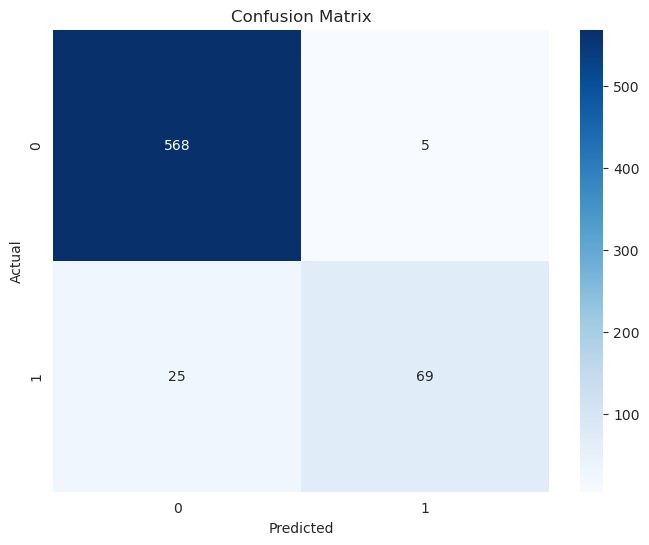

In [81]:
cm_1 = confusion_matrix(y_test, y_pred_gb)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_1, annot=True, fmt="d", cmap="Blues")

plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

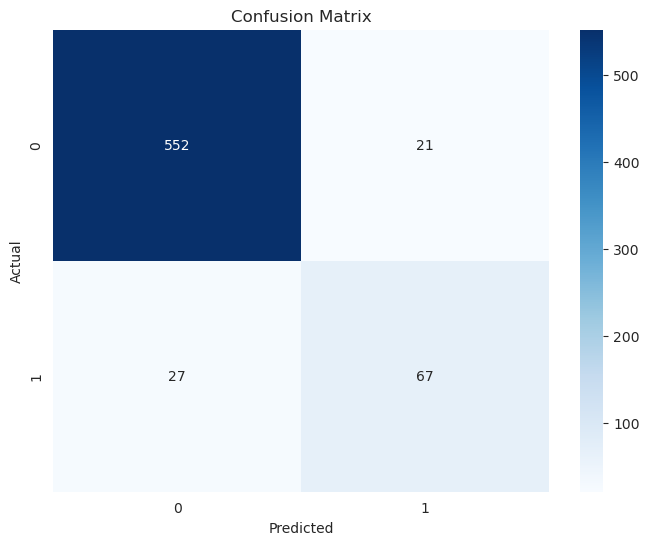

In [80]:
cm_2 = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_2, annot=True, fmt="d", cmap="Blues")

plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9


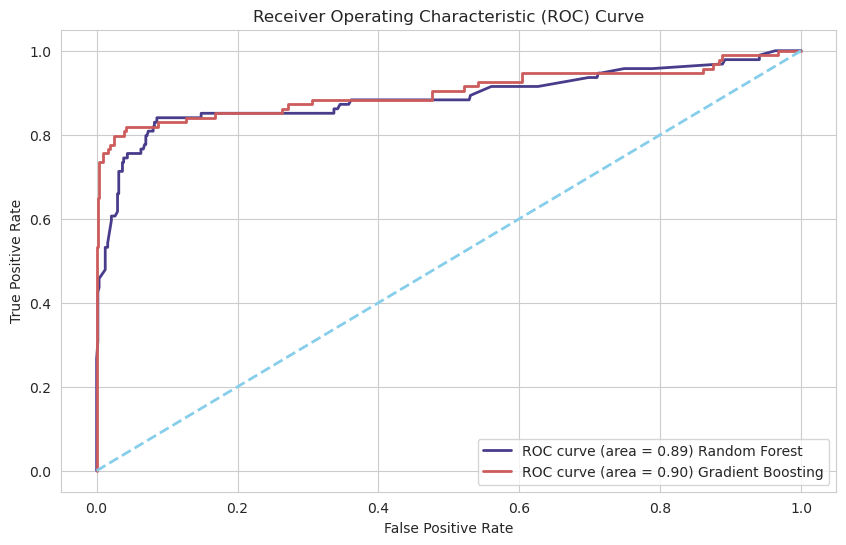

In [85]:
y_pred_proba_rf = rf_model.predict_proba(X_test)[:, 1]
y_pred_proba_gb = gb_model_best.predict_proba(X_test)[:, 1]

fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_proba_rf)
roc_auc_rf = roc_auc_score(y_test, y_pred_proba_rf)

fpr_gb, tpr_gb, _ = roc_curve(y_test, y_pred_proba_gb)
roc_auc_gb = roc_auc_score(y_test, y_pred_proba_gb)

plt.figure(figsize=(10, 6))
plt.plot(fpr_rf, tpr_rf, color='darkslateblue', lw=2, label='ROC curve (area = %0.2f) Random Forest' % roc_auc_rf)
plt.plot(fpr_gb, tpr_gb, color='indianred', lw=2, label='ROC curve (area = %0.2f) Gradient Boosting' % roc_auc_gb)
plt.plot([0, 1], [0, 1], color='skyblue', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

Выглядит так, что получили неплохие модели

Сделаем такой же анализ для `catboost.CatBoostClassifier`

In [82]:
catboost_model = catboost.CatBoostClassifier()

# Определение сетки гиперпараметров для перебора
param_grid = {
    'depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'l2_leaf_reg': [3, 5, 7],
}

catboost_grid = GridSearchCV(catboost_model, param_grid, scoring='roc_auc', cv=3)
catboost_grid.fit(X_train, y_train)

# Вывод наилучших гиперпараметров
print("Best params", catboost_grid.best_params_)

0:	learn: 0.6838568	total: 5.86ms	remaining: 5.85s
1:	learn: 0.6748960	total: 7.51ms	remaining: 3.75s
2:	learn: 0.6689186	total: 9.11ms	remaining: 3.03s
3:	learn: 0.6570716	total: 10.2ms	remaining: 2.54s
4:	learn: 0.6499769	total: 11.7ms	remaining: 2.33s
5:	learn: 0.6420565	total: 12.8ms	remaining: 2.12s
6:	learn: 0.6342727	total: 13.9ms	remaining: 1.97s
7:	learn: 0.6264814	total: 14.8ms	remaining: 1.83s
8:	learn: 0.6180620	total: 15.7ms	remaining: 1.73s
9:	learn: 0.6114868	total: 16.7ms	remaining: 1.65s
10:	learn: 0.6047913	total: 17.8ms	remaining: 1.6s
11:	learn: 0.5976563	total: 18.7ms	remaining: 1.54s
12:	learn: 0.5903087	total: 19.4ms	remaining: 1.47s
13:	learn: 0.5834735	total: 20.2ms	remaining: 1.43s
14:	learn: 0.5746825	total: 21ms	remaining: 1.38s
15:	learn: 0.5683122	total: 21.7ms	remaining: 1.33s
16:	learn: 0.5593866	total: 22.3ms	remaining: 1.29s
17:	learn: 0.5532682	total: 23.1ms	remaining: 1.26s
18:	learn: 0.5478174	total: 23.8ms	remaining: 1.23s
19:	learn: 0.5397764	tota

In [86]:
# Обучение модели с наилучшими гиперпараметрами
best_catboost = catboost_grid.best_estimator_
best_catboost.fit(X_train, y_train)

# Вычисление ROC-AUC для тестового набора данных
y_pred = best_catboost.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred)
print("ROC-AUC:", roc_auc)

0:	learn: 0.6094465	total: 1.4ms	remaining: 1.39s
1:	learn: 0.5444309	total: 2.48ms	remaining: 1.24s
2:	learn: 0.4876460	total: 3.42ms	remaining: 1.14s
3:	learn: 0.4298909	total: 4.48ms	remaining: 1.11s
4:	learn: 0.4018272	total: 5.67ms	remaining: 1.13s
5:	learn: 0.3710570	total: 6.48ms	remaining: 1.07s
6:	learn: 0.3515645	total: 7.33ms	remaining: 1.04s
7:	learn: 0.3289205	total: 8.47ms	remaining: 1.05s
8:	learn: 0.3107860	total: 9.67ms	remaining: 1.06s
9:	learn: 0.2981580	total: 13.3ms	remaining: 1.31s
10:	learn: 0.2891070	total: 14.3ms	remaining: 1.29s
11:	learn: 0.2781618	total: 15.2ms	remaining: 1.25s
12:	learn: 0.2687858	total: 16ms	remaining: 1.22s
13:	learn: 0.2613256	total: 16.9ms	remaining: 1.19s
14:	learn: 0.2522605	total: 18ms	remaining: 1.18s
15:	learn: 0.2479313	total: 19.5ms	remaining: 1.2s
16:	learn: 0.2407215	total: 20.5ms	remaining: 1.18s
17:	learn: 0.2331353	total: 21.4ms	remaining: 1.17s
18:	learn: 0.2274745	total: 22.2ms	remaining: 1.15s
19:	learn: 0.2219213	total: 

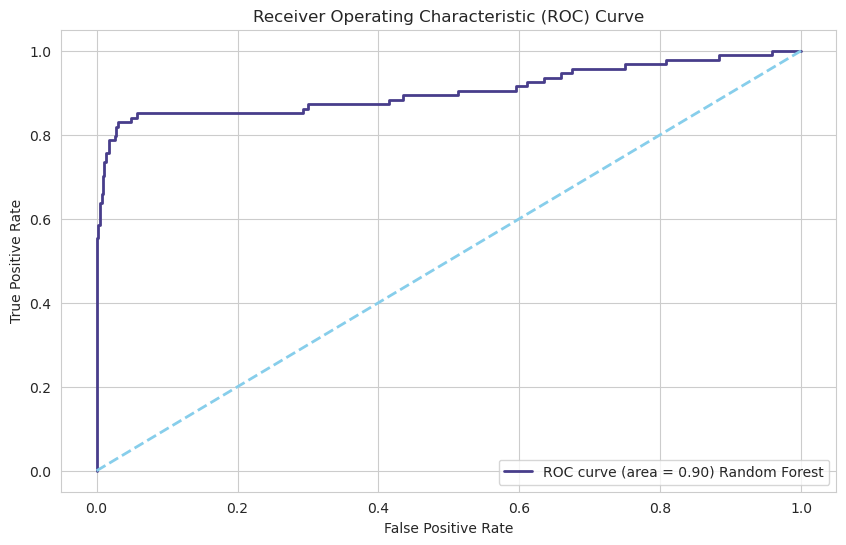

In [89]:
fpr, tpr, _ = roc_curve(y_test, y_pred)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkslateblue', lw=2, label='ROC curve (area = %0.2f) Random Forest' % roc_auc)
plt.plot([0, 1], [0, 1], color='skyblue', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

Тоже выглядит хорошо

### Задание 5. Рисуем

**дополнительно 0.5 балла**

Наверняка, в процессе выполнения этого задания вас переполняли какие-то эмоции. Нарисуйте что-то, что бы могло бы передать их (я сам не умею, так что, если это будет просто квадрат, тоже подойдет). Прикрепите сюда свой рисунок:

У меня нет рисунка, но есть нарисованный мем про мою домашку 🥲

![image](https://memepedia.ru/wp-content/uploads/2019/11/screenshot_7.png)

### Therapy time

Напишите здесь ваши впечатления о задании (можно и не о задании): было ли интересно, было ли слишком легко или наоборот сложно и тд. Также сюда можно написать свои идеи по улучшению заданий, а также предложить данные, на основе которых вы бы хотели построить следующие дз.

**Ваши мысли:**